# Exercises - GEO4902-01 - General modeling concepts

[Save google-collab as jupyter notebook, with your name in the filename, and upload on canvas]

# Exercise 01A - How to access the latest weather forecast:

In [19]:
# import python packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy as cy
from matplotlib.dates import DateFormatter
import netCDF4

##### Specify the file on the thredds server. For example the full file of latest forecast of the AROME Arctic weather model. Note, at this point only metadata is retrieved

In [20]:
url='https://thredds.met.no/thredds/dodsC/aromearcticlatest/latest/arome_arctic_lagged_12_h_latest_2_5km_latest.nc'
dataset = xr.open_dataset(url, engine='netcdf4')

### Metadata

In [21]:
dataset

<xarray.Dataset> Size: 10GB
Dimensions:                    (time: 58, ensemble_member: 4, pressure: 2,
                                height_above_msl: 1, height0: 1, height1: 1,
                                height2: 1, x: 739, y: 949)
Coordinates:
  * time                       (time) datetime64[ns] 464B 2024-09-12T09:00:00...
  * ensemble_member            (ensemble_member) int16 8B 0 1 2 3
  * pressure                   (pressure) float32 8B 850.0 925.0
  * height_above_msl           (height_above_msl) float32 4B 0.0
  * height0                    (height0) float32 4B 2.0
  * height1                    (height1) float32 4B 0.0
  * height2                    (height2) float32 4B 10.0
  * x                          (x) float32 3kB 2.786e+05 2.811e+05 ... 2.124e+06
  * y                          (y) float32 4kB -8.98e+05 ... 1.472e+06
    longitude                  (y, x) float64 6MB ...
    latitude                   (y, x) float64 6MB ...
Data variables: (12/15)
    forecast_reference_time    datetime64[ns] 8B ...
    projection_lambert         int32 4B ...
    x_wind_pl                  (time, pressure, ensemble_member, y, x) float32 1GB ...
    y_wind_pl                  (time, pressure, ensemble_member, y, x) float32 1GB ...
    air_temperature_pl         (time, pressure, ensemble_member, y, x) float32 1GB ...
    air_temperature_2m         (time, height0, ensemble_member, y, x) float32 651MB ...
    ...                         ...
    cloud_area_fraction        (time, height1, ensemble_member, y, x) float32 651MB ...
    air_pressure_at_sea_level  (time, height_above_msl, ensemble_member, y, x) float32 651MB ...
    precipitation_amount_acc   (time, height1, ensemble_member, y, x) float32 651MB ...
    snowfall_amount_acc        (time, height1, ensemble_member, y, x) float32 651MB ...
    wind_speed_of_gust         (time, height2, ensemble_member, y, x) float32 651MB ...
    fog_area_fraction          (time, height1, ensemble_member, y, x) float32 651MB ...
Attributes: (12/23)
    Conventions:                     CF-1.6, ACDD
    institution:                     Norwegian Meteorological Institute, MET ...
    institution_short_name:          NO/MET
    creator_url:                     met.no
    source:                          AROME-Arctic 2.5km
    title:                           AROME_Arctic 2.5km
    ...                              ...
    dataset_production_status:       Active
    iso_topic_category:              climatologyMeteorologyAtmosphere
    spatial_representation:          grid
    naming_authority:                no.met
    history:                         2024-09-12T11:22:53 creation by fimex
    DODS_EXTRA.Unlimited_Dimension:  time

Metadata is descriptive and often standardized information about a dataset. It is information that allows new users of a dataset to understand the contents of a file that was created by someone else. By including metadata, your data set can be used as intended by many more people and the information is useful log past the creators interest in it or even their lifetime.

Many now operate by principles of fair data, some data centers REQUIRE it. This entails using standardized conventions such as CF and ACDD in the file above. These conventions give users a standardized vocabulary and structure such that future users can easily interpret and use the data. Here CF mainly gives a standard for the file structure, variable names and standardized attributes. ACDD focuses more on metadata and and global attributes such that the data is easily discoverable for potential users.

### Find a specific point and plot the forecast. 
###### Note AROME Arctic is on an irregular grid, so the xarray.sel functionality does not work:

In [22]:
# Function to find a specific lat/lon location 

import math
import numpy as np

def findindex(alat,alon,plat,plon):
    #finding identical location of pos plat, plon in array alat[],alon[]
    abslat = np.abs(alat-plat)
    abslon = np.abs(alon-plon)
    c = np.maximum(abslon,abslat)
    x, y = np.where(c == np.min(c))
    #print(alats[x,y],alon[x,y])
    x=int(x)
    y=int(y)
   
    return (x,y)

In [23]:
#Find a specific location, for example for Longyearbyen

lon = 15.46; lat= 78.24
[xloc,yloc] = findindex(dataset.latitude,dataset.longitude,lat,lon) 

t2m_point = dataset.air_temperature_2m[:,0,1,xloc,yloc]

print('longitude =', float(dataset.longitude[xloc,yloc].values.round(2)))
print('latitude =', float(dataset.latitude[xloc,yloc].values.round(2)))

#Note the number of dimentsions of the temperature array and cross-check with the metadata

longitude = 15.49
latitude = 78.25


/tmp/ipykernel_487751/4292047029.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x=int(x)
/tmp/ipykernel_487751/4292047029.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y=int(y)


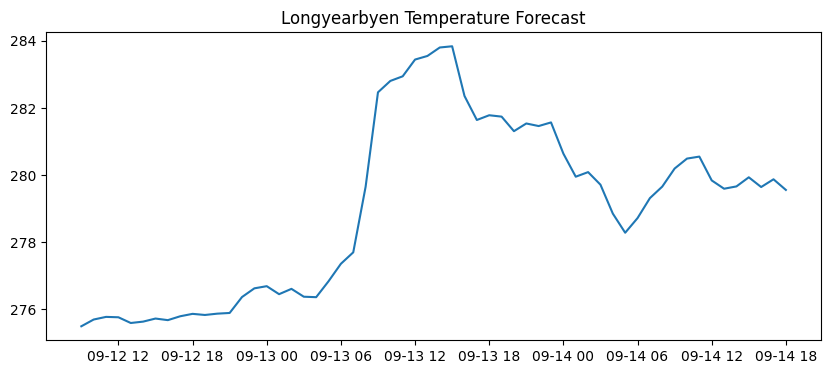

In [24]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(dataset.time, t2m_point, '-')

plt.title("Longyearbyen Temperature Forecast")
plt.show()

### Plot one forecast on a map

#### Choose ensemble member and timestep 

In [58]:
def plot_t2m_map(ensemble_mem, date_time, lon, lat):
    time_hours = dataset.air_temperature_2m.time.astype('datetime64[h]')
    print(date_time)
    target_time = np.datetime64(date_time)
    timestep = np.where(time_hours == target_time)[0][0]

    t2m_area = dataset.air_temperature_2m[timestep,0,ensemble_mem,:,:]
    date_time = dataset.air_temperature_2m.time.values[timestep]


    projection = cy.crs.LambertConformal(central_longitude =dataset.projection_lambert.longitude_of_central_meridian,
                                        central_latitude  =dataset.projection_lambert.latitude_of_projection_origin,
                                        standard_parallels = dataset.projection_lambert.standard_parallel)
    fig = plt.figure(figsize=[6, 6])

    ax = plt.subplot(1, 1, 1, projection=projection)
    ax.set_extent([lon - 1.5, lon + 1.5, lat-1.5, lat+1.5], cy.crs.PlateCarree())

    ax.gridlines()
    ax.add_feature(cy.feature.COASTLINE, zorder=2) 
    cf = ax.pcolormesh(t2m_area.longitude,t2m_area.latitude,t2m_area[:,:],transform=cy.crs.PlateCarree(), zorder=1)
    cf.set_clim(270,285)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels   = False
    gl.right_labels = False
    
    cbaxes = fig.add_axes([0.92, 0.025, 0.025, 0.9])
    cbar = plt.colorbar(cf, cax=cbaxes, shrink=0.5, orientation='vertical', extend='both')

    fig.suptitle(f'Temperature forecast {date_time}')

/tmp/ipykernel_487751/1435262085.py:2: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  time_hours = dataset.air_temperature_2m.time.astype('datetime64[h]')


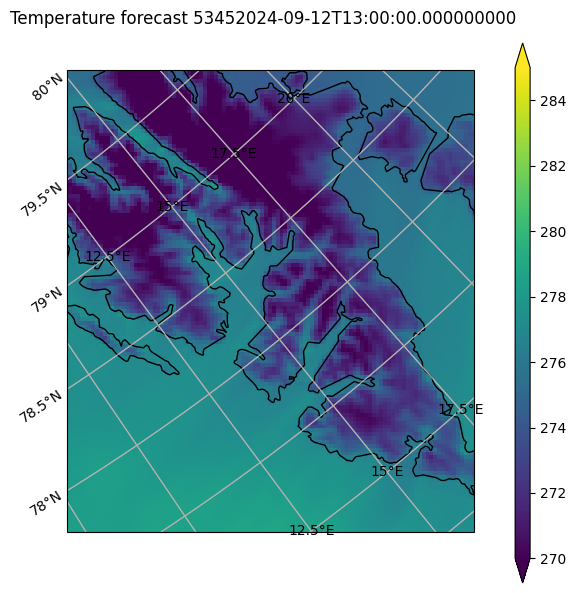

In [59]:
plot_t2m_map(ensemble_mem = 1, date_time = '2024-09-12T13', lon = 15.46, lat= 78.24)

In [60]:
from platform import python_version
#import nc_time_axis
import zarr 
import xarray as xr
import matplotlib as mpl
import cftime
import dask as da
import cmcrameri as cm
import scipy
import intake
import seaborn
#import xesmf
import cartopy as crs
import netCDF4

print('python: version {}'.format(python_version()))
#print('nc_time_axis: version {}'.format(nc_time_axis.__version__))
print('zarr: version {}'.format(zarr.__version__))
print('xarray: version {}'.format(xr.__version__))
print('matplotlib: version {}'.format(mpl.__version__))
print('cftime: version {}'.format(cftime.__version__))
print('dask: version {}'.format(da.__version__))
print('cmcrameri: version {}'.format(cm.__version__))
print('scipy: version {}'.format(scipy.__version__))
print('intake: version {}'.format(intake.__version__))
print('seaborn: version {}'.format(seaborn.__version__))
#print('xesmf: version {}'.format(xesmf.__version__))
print('cartopy: version {}'.format(crs.__version__))
print('netCDF4: version {}'.format(netCDF4.__version__))

python: version 3.10.12
zarr: version 2.18.3
xarray: version 2024.7.0
matplotlib: version 3.9.2
cftime: version 1.6.4
dask: version 2024.8.2
cmcrameri: version 1.8
scipy: version 1.14.1
intake: version 2.0.7
seaborn: version 0.13.2
cartopy: version 0.23.0
netCDF4: version 1.7.1.post2
